In [134]:
from sympy import *
from safe_region_utils import *
init_printing()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up example

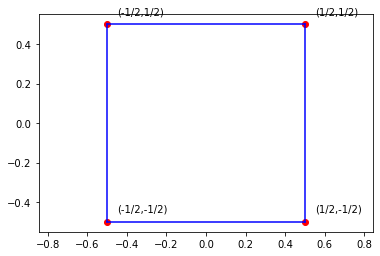

In [55]:
x, y = symbols("x y")
## Short Example ##
w = 0.5
square_points: list = [
    geometry.Point(val) for val in [[w, -w], [w, w], [-w, w], [-w, -w]]
]
square: geometry.Polygon = Polygon(*square_points)
plot_polygon(square)

w = Symbol("w", real=True, positive=True, nonzero=True)
square_points: list = [
    geometry.Point(val) for val in [[w, -w], [w, w], [-w, w], [-w, -w]]
]
square_param: geometry.Polygon = Polygon(*square_points)
compute_polygon_angles(square_param)
# traj_piecewise = Piecewise((sin(x / 2), x < 0), (x / 2, x >= 0))
# plot(traj_piecewise)
# plt.show()

In [145]:
a = Symbol("a", real=True, nonzero=True)
b = Symbol("b", real=True, nonzero=True)
c = Symbol("c", real=True, nonzero=True)

In [152]:
traj = a*x**2 + b*x +c
traj

In [175]:
traj = a*sin(b*x)
sinderiv = diff(traj, x)
sinderiv

In [178]:
solve(Eq(sinderiv, 0), x)

In [150]:
solve(Eq(diff(a*x**2, x), 0), x)

In [144]:
solve(Eq(diff(traj, x), 0), x)

In [154]:
traj

In [ ]:
angles, vertex_pairs = compute_polygon_angles(square)
# find_transitions(-y + traj, angles, x, y, domain)  # fails bc Intersection type poorly handled
find_transitions(-y + traj, angles, x, y, Reals)  

In [164]:
domain=Reals
traj = -y + a*x**2 + b*x +c

transitions: set = {}
# Compute slope symbolically
df_dy, df_dx = slope_sym(traj, x, y)
for angle in angles:
    # 2 vectors <x1, y1> <x2, y2>
    # parallel iff y1*x2 = x1*y2
    # use vectors <dfdx, dfdy> <cos(theta), sin(theta)>
    soln = solveset(Eq(df_dx * sin(angle), df_dy * cos(angle)), x, domain=domain)

    if soln == S.EmptySet:
        soln = solveset(
            Eq(df_dx * sin(angle), df_dy * cos(angle)), y, domain=domain
        )
        if soln != S.EmptySet and type(soln) != list:
            # In this case, type(soln): S.FiniteSet
            soln = [{y: soln_elem} for soln_elem in list(soln)]
    else:
        # Pack into list of dict so it's clear which variable has been solved for
        try:
            soln = [{x: soln_elem} for soln_elem in list(soln)]
        except:
            print(soln)

    for elem in soln:
        if angle in transitions:
            transitions[angle].append(elem)
        else:
            transitions[angle] = [elem]
# soln above may still be symbolic, so we have to evaluate the expression
# that's what happens below

transition_points = {}
set_of_transitions = set()
traj_eqn = Eq(traj, 0)
for angle, solns in transitions.items():
    for pair in solns:
        # pair should always be a dictionary
        assert type(pair) == dict, "Solution element was not a dictionary!"
        # pair looks like {x: f(y)} or {y: f(x)}
        # remove one variable from equation by substituting pair into traj_eqn
        traj_eqn_single_var = traj_eqn.subs(pair)

        # before going further, figure out the variable for
        # which pair contains a solution
        soln_var = [k for k in pair][0]  # variable is the dict key
        other_var = y if soln_var == x else x

        # traj_eqn used to have two variables but now has only one
        single_var_solns = solve(traj_eqn_single_var, other_var)

        for single_var_soln in single_var_solns:
            # substitute in single_var_soln to solve for soln_var
            solved_eqn = Eq(soln_var, pair[soln_var]).subs(
                other_var, single_var_soln
            )
            # with this, we have a solution for the transition point
            if soln_var == x:
                print("x-coord:", solved_eqn.rhs)
                print("y-coord:", single_var_soln)
                transition_point = Point(solved_eqn.rhs, single_var_soln)
            elif soln_var == y:
                transition_point = Point(single_var_soln, solved_eqn.rhs)
            set_of_transitions.add(transition_point)
            if angle in transition_points:
                transition_points[angle].append(transition_point)
            else:
                transition_points[angle] = [transition_point]


x-coord: -b/(2*a)
y-coord: c - b**2/(4*a)
x-coord: -b/(2*a)
y-coord: c - b**2/(4*a)


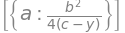

In [108]:
single_var_solns

In [112]:
pair

In [111]:
traj_eqn_single_var

In [113]:
solve(traj_eqn, y)

In [172]:
domain = Interval(-12, 9)
xbounds = [-15, 12]
ybounds = [-3, 6]
example_name = "Sine-Linear with Square"

traj = a*x**2 + b*x +c

cond = compute_unsafe_cond_symbolic(
    x,
    y,
    square,
    traj,
    Reals,
    add_notches=False,
)
print("Boolean condition for unsafe region:\n", cond)

Boolean condition for unsafe region:
 ((x >= -oo) & (x <= 1/2 - b/(2*a)) & ((y - Piecewise((oo*a - oo*b + c, x < -oo), (a*(x - 1/2)**2 + b*(x - 1/2) + c, x <= 1/2 - b/(2*a)), (c - b**2/(4*a), True)) - 1/2)*(y - Piecewise((oo*a - oo*b + c, x < -oo), (a*(x + 1/2)**2 + b*(x + 1/2) + c, x <= -1/2 - b/(2*a)), (c - b**2/(4*a), True)) + 1/2) <= 0)) | ((x >= -oo) & (x <= 1/2 - b/(2*a)) & ((y - Piecewise((oo*a - oo*b + c, x < -oo), (a*(x - 1/2)**2 + b*(x - 1/2) + c, x <= 1/2 - b/(2*a)), (c - b**2/(4*a), True)) + 1/2)*(y - Piecewise((oo*a - oo*b + c, x < -oo), (a*(x + 1/2)**2 + b*(x + 1/2) + c, x <= -1/2 - b/(2*a)), (c - b**2/(4*a), True)) - 1/2) <= 0)) | ((x <= oo) & (x >= -1/2 - b/(2*a)) & ((y - Piecewise((c - b**2/(4*a), x < -1/2 - b/(2*a)), (a*(x + 1/2)**2 + b*(x + 1/2) + c, x <= oo), (oo*a + oo*b + c, True)) - 1/2)*(y - Piecewise((c - b**2/(4*a), x < 1/2 - b/(2*a)), (a*(x - 1/2)**2 + b*(x - 1/2) + c, x <= oo), (oo*a + oo*b + c, True)) + 1/2) <= 0)) | ((x <= oo) & (x >= -1/2 - b/(2*a)) & ((y


Plotting dot grid visualization of safe and unsafe regions. This may take up to 20 seconds to plot.
Once displayed, close plot to continue example...



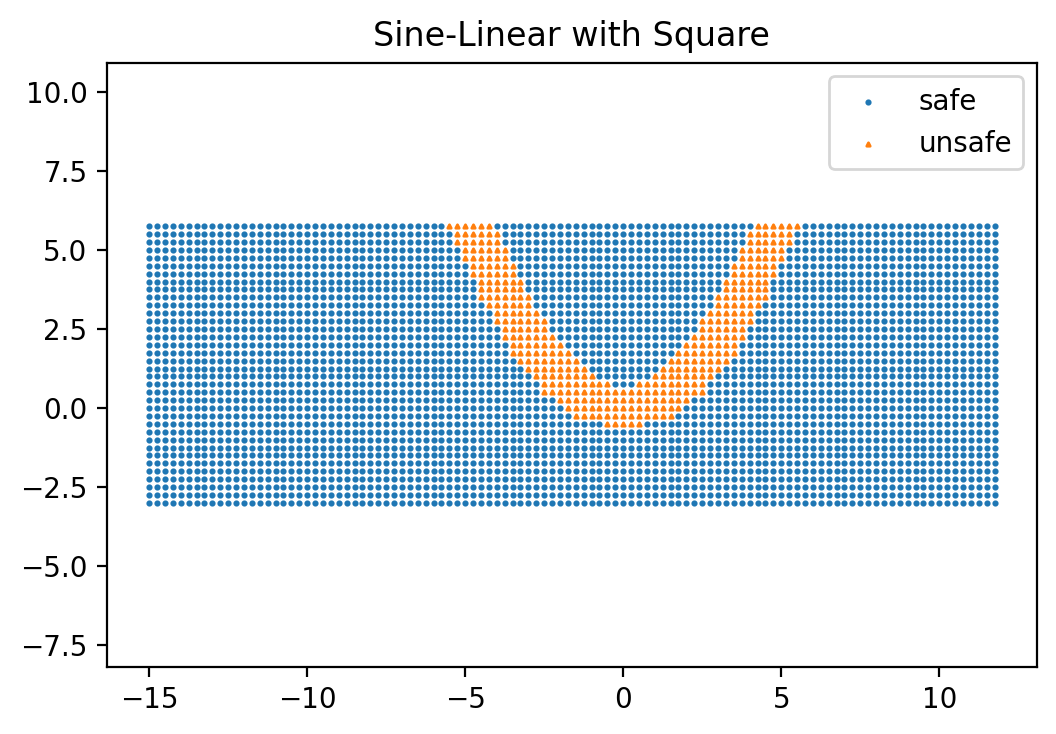

Mathematica command for plotting:
 
Show[
    RegionPlot[((x + 1/2 >= 0) && (y + 1/2 >= 0) && (1/2 - x >= 0) && (1/2 - y >= 0)) || ((x + 1/2 <= 0) && (y + 1/2 <= 0) && (1/2 - x <= 0) && (1/2 - y <= 0)) || ((x - 17/2 >= 0) && (19/2 - x >= 0) && (-81*a + y + 1/2 >= 0) && (81*a - y + 1/2 >= 0)) || ((x + 25/2 >= 0) && (-x - 23/2 >= 0) && (-144*a + y + 1/2 >= 0) && (144*a - y + 1/2 >= 0)) || ((x - 17/2 <= 0) && (19/2 - x <= 0) && (-81*a + y + 1/2 <= 0) && (81*a - y + 1/2 <= 0)) || ((x + 25/2 <= 0) && (-x - 23/2 <= 0) && (-144*a + y + 1/2 <= 0) && (144*a - y + 1/2 <= 0)) || ((x >= -25/2) && (x <= 1/2) && ((y - Piecewise[{{144*a, x < -25/2}, {a*(x + 1/2)^2, x <= -1/2}, {0, True}}] - 1/2)*(y - Piecewise[{{144*a, x < -23/2}, {a*(x - 1/2)^2, x <= 1/2}, {0, True}}] + 1/2) <= 0)) || ((x >= -25/2) && (x <= 1/2) && ((y - Piecewise[{{144*a, x < -25/2}, {a*(x + 1/2)^2, x <= -1/2}, {0, True}}] + 1/2)*(y - Piecewise[{{144*a, x < -23/2}, {a*(x - 1/2)^2, x <= 1/2}, {0, True}}] - 1/2) <= 0)) || ((x >= -1/2

In [75]:
print(
    "\nPlotting dot grid visualization of safe and unsafe regions.", 
    "This may take up to 20 seconds to plot.\nOnce displayed, close plot to continue example...\n"
)

plot_condition(x, y, cond.subs(a, 1/4), xbounds, ybounds, title=example_name)
mathematica_output = print_mathematica(
    x, y, cond, xbounds, ybounds, traj_piecewise, square
)
print("Mathematica command for plotting:\n", mathematica_output)

In [76]:
traj

In [77]:
cond.subs(a, 1)

⎛                      ⎛    ⎛⎧   144      for x < -25/2⎞    ⎞ ⎛    ⎛⎧   144      for x < -23/2⎞    ⎞    ⎞   ⎛          
⎜                      ⎜    ⎜⎪                         ⎟    ⎟ ⎜    ⎜⎪                         ⎟    ⎟    ⎟   ⎜          
⎜                      ⎜    ⎜⎪         2               ⎟   1⎟ ⎜    ⎜⎪         2               ⎟   1⎟    ⎟   ⎜          
⎜x ≥ -25/2 ∧ x ≤ 1/2 ∧ ⎜y - ⎜⎨(x + 1/2)   for x ≤ -1/2 ⎟ - ─⎟⋅⎜y - ⎜⎨(x - 1/2)    for x ≤ 1/2 ⎟ + ─⎟ ≤ 0⎟ ∨ ⎜x ≥ -25/2 
⎜                      ⎜    ⎜⎪                         ⎟   2⎟ ⎜    ⎜⎪                         ⎟   2⎟    ⎟   ⎜          
⎜                      ⎜    ⎜⎪    0         otherwise  ⎟    ⎟ ⎜    ⎜⎪    0         otherwise  ⎟    ⎟    ⎟   ⎜          
⎝                      ⎝    ⎝⎩                         ⎠    ⎠ ⎝    ⎝⎩                         ⎠    ⎠    ⎠   ⎝          

            ⎛    ⎛⎧   144      for x < -25/2⎞    ⎞ ⎛    ⎛⎧   144      for x < -23/2⎞    ⎞    ⎞   ⎛                     
            ⎜    ⎜⎪                    

In [61]:
square.vertices